# SINDy example code

In [1]:
import numpy as np
from scipy.integrate import odeint
from sklearn.model_selection import KFold, GridSearchCV

from context import sindy
from sindy import SINDy
from sindy.differentiation import FiniteDifference, SmoothedFiniteDifference
from sindy.optimizers import STLSQ, SR3

import matplotlib.pyplot as plt
%matplotlib inline

## Generate training data

### harmonic oscillator

In [2]:
def rhs_harmonic_oscillator(y, t):
    dy0 = y[1]
    dy1 = -0.3 * y[0]
    return [dy0, dy1]

In [3]:
n_points = 1000

x0 = [0, 1]
t = np.linspace(0, 10, n_points)
x = odeint(rhs_harmonic_oscillator, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

### lorenz

In [2]:
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

In [3]:
n_points = 1000

x0 = [8,27,-7]
t = np.linspace(0, 10, n_points)
x = odeint(lorenz, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

## Basic examples

### Simplest version

In [9]:
model = SINDy(feature_names=['x','y','z'])
model.fit(x_train, t_train)

SINDy(differentiation_method=<sindy.differentiation.differentiation_methods.FiniteDifference object at 0x1a22531ed0>,
      feature_library=PolynomialFeatures(degree=2, include_bias=True,
                                         interaction_only=False, order='C'),
      feature_names=['x', 'y', 'z'], n_jobs=1,
      optimizer=STLSQ(alpha=0.0, ridge_kw=None, threshold=0.1))

In [10]:
print(model.equations())

['-9.961 x + 9.961 y', '27.559 x + -0.922 y + -0.988 x z', '-2.648 z + 0.993 x y']


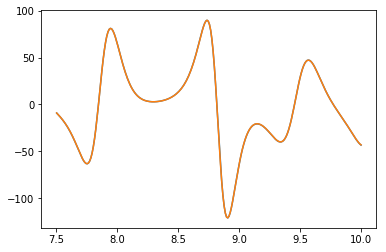

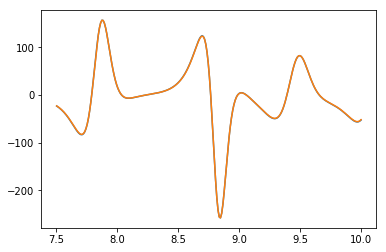

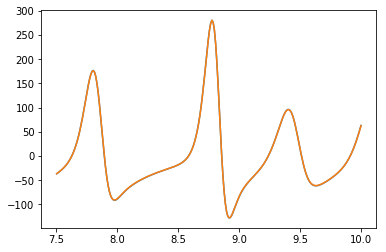

In [8]:
centered_difference = FiniteDifference(order=2, drop_endpoints=False)
for i in range(x_test.shape[1]):
    plt.figure()
    plt.plot(t_test, centered_difference(x_test, t_test)[:,i])
    plt.plot(t_test, model.predict(x_test)[:,i])

## Change some options

In [9]:
from sindy.optimizers import STLSQ, SR3, LASSO, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

### SR3

['-0.279  + -10.112  + 10.080 x0', '1.419  + 27.555  + -0.851 x0 + -0.139 x1 + -0.987 1 x1', '-0.245  + 0.250 x0 + -2.593 x1 + 0.985 1 x0']


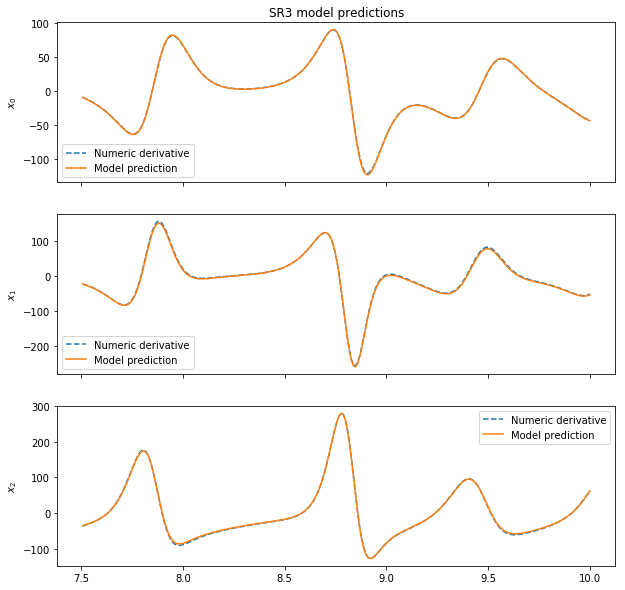

In [10]:
model = SINDy(optimizer=SR3())
model.fit(x_train, t_train)

print(model.equations())

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, centered_difference(x_test, t_test)[:,i], '--', label='Numeric derivative')
    axs[i].plot(t_test, model.predict(x_test)[:,i], label='Model prediction')
    axs[i].legend()
    axs[i].set(ylabel='$x_{}$'.format(i))

axs[0].set(title='SR3 model predictions')
fig.show()

### LASSO

['3.782 x0 + -0.020 x1 + 0.235 1^2 + -0.253 1 x0 + -0.261 1 x1 + 0.090 x0^2 + 0.162 x0 x1 + -0.010 x1^2', '22.938  + 0.809 x0 + -0.100 1^2 + 0.060 1 x0 + -0.874 1 x1 + -0.008 x0^2 + -0.030 x0 x1 + 0.006 x1^2', '-2.298 x1 + 0.076 1^2 + 0.936 1 x0 + 0.009 x0^2 + -0.001 x0 x1 + -0.014 x1^2']


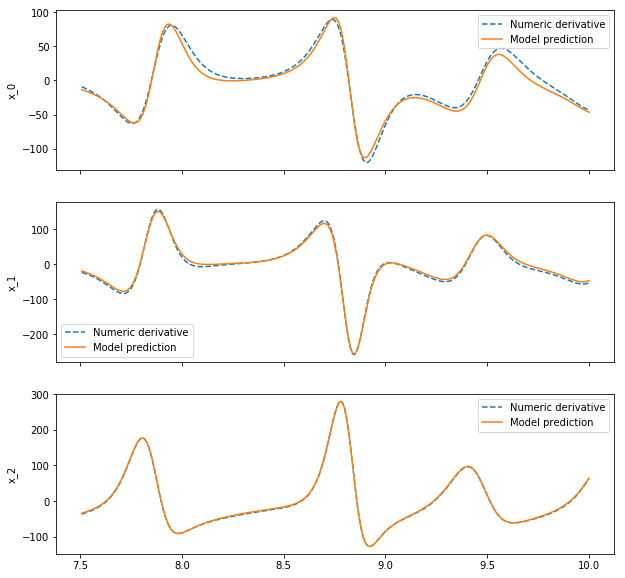

In [11]:
model = SINDy(optimizer=LASSO(max_iter=1000, alpha=10))
model.fit(x_train, t_train)

print(model.equations())

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, centered_difference(x_test, t_test)[:,i], '--', label='Numeric derivative')
    axs[i].plot(t_test, model.predict(x_test)[:,i], label='Model prediction')
    axs[i].legend()
    axs[i].set(ylabel='x_{}'.format(i))

fig.show()

### Elastic net

['3.759 x0 + -0.021 x1 + 0.235 1^2 + -0.255 1 x0 + -0.262 1 x1 + 0.091 x0^2 + 0.163 x0 x1 + -0.010 x1^2', '20.759  + 2.005 x0 + 0.020 x1 + -0.153 1^2 + 0.112 1 x0 + -0.817 1 x1 + -0.025 x0^2 + -0.060 x0 x1 + 0.008 x1^2', '-2.293 x1 + 0.077 1^2 + 0.935 1 x0 + 0.009 x0^2 + -0.001 x0 x1 + -0.015 x1^2']


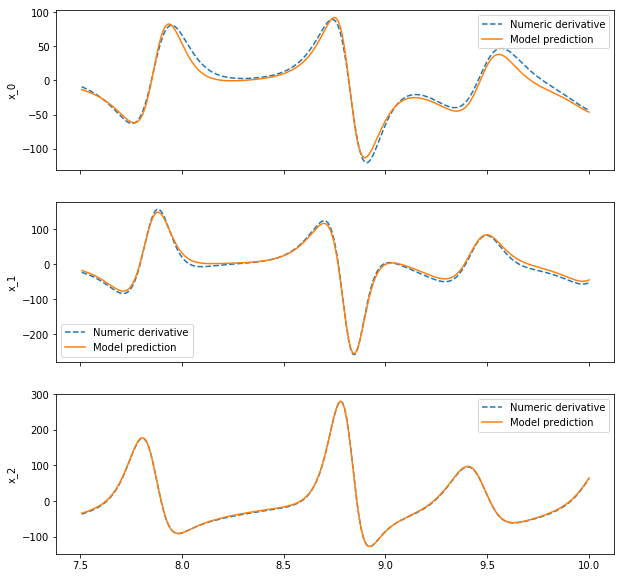

In [12]:
model = SINDy(optimizer=ElasticNet(max_iter=1000, alpha=10, l1_ratio=0.99))
model.fit(x_train, t_train)

print(model.equations())

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, centered_difference(x_test, t_test)[:,i], '--', label='Numeric derivative')
    axs[i].plot(t_test, model.predict(x_test)[:,i], label='Model prediction')
    axs[i].legend()
    axs[i].set(ylabel='x_{}'.format(i))

fig.show()

### Add noise

In [13]:
np.random.seed(99)
x_train_noisy = x_train + 0.5 * np.random.randn(*x_train.shape)
x_test_noisy = x_test + 0.5 * np.random.randn(*x_test.shape)


# Define a vanilla model
model = SINDy(optimizer=STLSQ(threshold=0.5))
model.fit(x_train_noisy, t_train)

# Define a model which uses a smoothed finite difference method
model_smooth = SINDy(
    differentiation_method=SmoothedFiniteDifference(),
    optimizer=STLSQ(threshold=0.5)
)
model_smooth.fit(x_train_noisy, t_train)

# There's something weird going on with the equations for model_smooth?
print(model.equations())
print(model_smooth.equations())

['-9.713  + 9.784 x0', '-0.769  + 27.477  + -1.108 x0 + -0.980 1 x1', '-1.507  + -2.595 x1 + 0.990 1 x0']
['-0.613  + -9.591  + 9.661 x0', '24.822  + -0.932 1 x1', '-1.469  + -2.544 x1 + 0.975 1 x0']


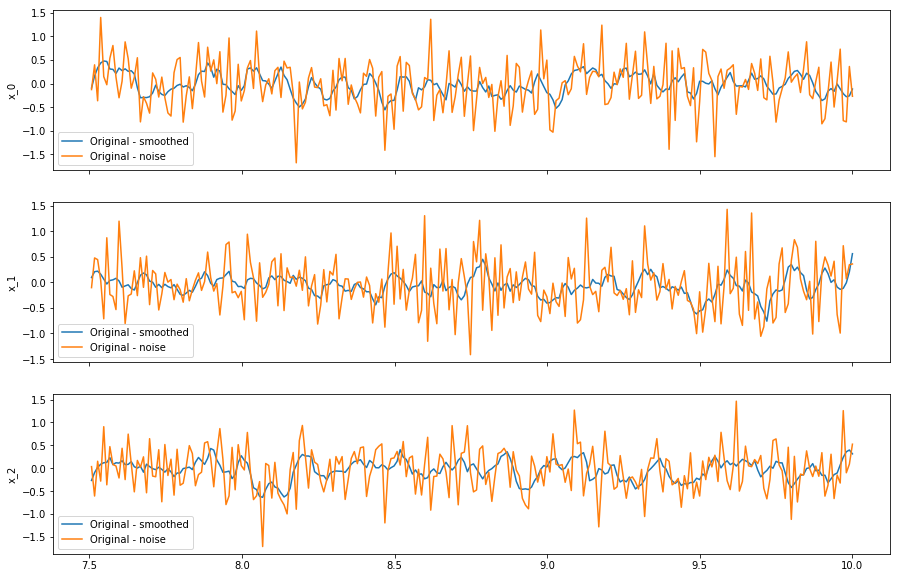

In [14]:
from scipy.signal import savgol_filter
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(15, 10))
x_test_smoothed = savgol_filter(x_test_noisy, 11, 3, axis=0)
for i in range(x_test.shape[1]):
#     axs[i].plot(t_test, x_test_noisy[:, i], '--', label='Noisy data')
#     axs[i].plot(t_test, x_test_smoothed[:, i], label='Smoothed')
#     axs[i].plot(t_test, x_test[:, i], ':', label='Original data')
    axs[i].plot(t_test, x_test[:, i] - x_test_smoothed[:, i], label='Original - smoothed')
    axs[i].plot(t_test, x_test[:, i] - x_test_noisy[:, i], label='Original - noise')
    
    axs[i].legend()
    axs[i].set(ylabel='x_{}'.format(i))

fig.show()

## Test SINDy class functions

### Printing model

In [15]:
print(model.get_feature_names())

assert len(model.get_feature_names()) == 10
# Test with larger polynomial library

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']


In [16]:
print(model.equations(precision=2))

['-9.71  + 9.78 x0', '-0.77  + 27.48  + -1.11 x0 + -0.98 1 x1', '-1.51  + -2.59 x1 + 0.99 1 x0']


In [17]:
print(model.coefficients())

[ 0.         -9.71342399  9.78380682  0.          0.          0.
  0.          0.          0.          0.        ]


### Predicting and simulating

In [18]:
model = SINDy()
model.fit(x_train, t_train)

print(model.equations())

['-9.961  + 9.961 x0', '27.559  + -0.922 x0 + -0.988 1 x1', '-2.648 x1 + 0.993 1 x0']


In [19]:
# Standard scoring function is R^2 coefficient of determination
print('(R^2) Score on train set:', model.score(x_train, t=t_train))
print('(R^2) Score on test set:', model.score(x_test, t=t_test))

(R^2) Score on train set: 0.9999419890544722
(R^2) Score on test set: 0.999974329657432


In [20]:
# Other (regression) scoring functions may be used
from sklearn.metrics import mean_squared_error
print('(MSE) Score on train set:', model.score(x_train, t=t_train, metric=mean_squared_error))
print('(MSE) Score on test set:', model.score(x_test, t=t_test, metric=mean_squared_error))

(MSE) Score on train set: 0.6265075423628065
(MSE) Score on test set: 0.13067446473773006


In [21]:
simulated_x = model.simulate(x_test[0, :], t_test)

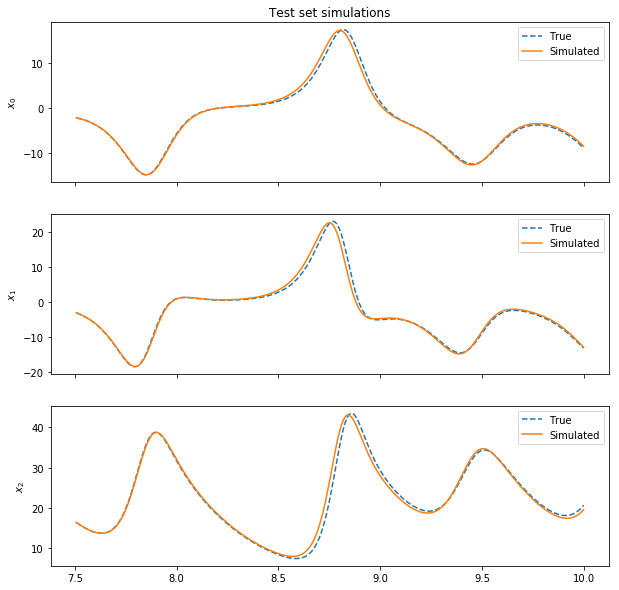

In [22]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:,i], '--', label='True')
    axs[i].plot(t_test, simulated_x[:,i], label='Simulated')
    axs[i].legend()
    axs[i].set(ylabel='$x_{}$'.format(i))

axs[0].set(title='Test set simulations')
fig.show()